In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Twitter_Sentiment_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
853207,4,1573131665,Mon Apr 20 23:50:56 PDT 2009,NO_QUERY,glowingskin,@xsophxgx yea exactly! have a good day at sch...
211981,0,1974622224,Sat May 30 13:30:35 PDT 2009,NO_QUERY,seomenno,"@EdWords Hey Ed, have fun @ fresh. Will there ..."
716634,0,2259756911,Sat Jun 20 18:06:42 PDT 2009,NO_QUERY,NinoNouveariche,@CarlynRae ugh no green
1205672,4,1986598072,Sun May 31 19:03:19 PDT 2009,NO_QUERY,Jmone5,@christina1080 ill check that out. sooo im don...
1308050,4,2012612122,Tue Jun 02 20:58:15 PDT 2009,NO_QUERY,amyg78,My brother's the best at giving house warming ...


In [3]:
df.shape

(1600000, 6)

In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [7]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
df['target'].unique()

array([0, 4], dtype=int64)

In [9]:
df['target'].nunique()

2

<Axes: xlabel='target', ylabel='count'>

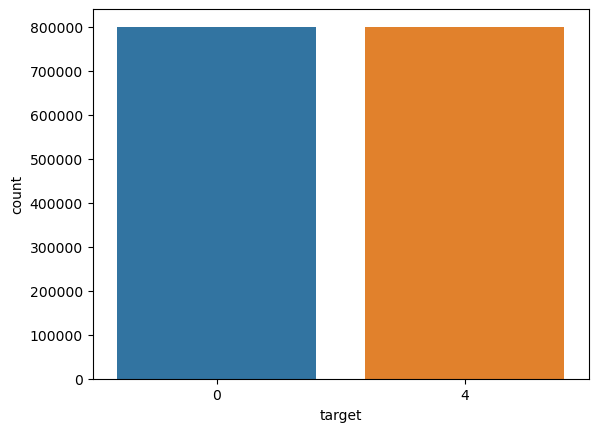

In [10]:
import seaborn as sns
sns.countplot(x='target', data=df)

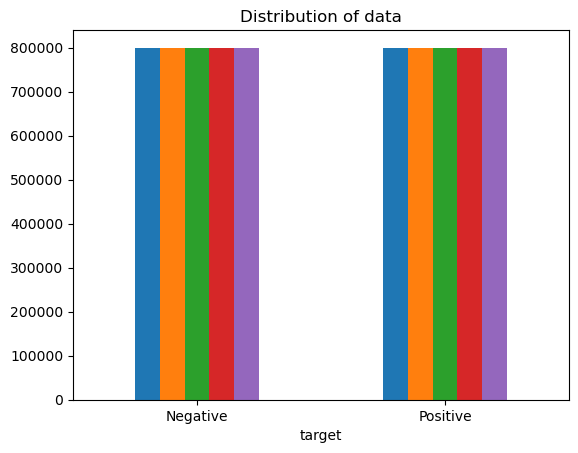

In [11]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

In [12]:
data=df[['text','target']]
data

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


In [13]:
data['target'] = data['target'].replace(4,1) ## Assuming 1 to be a positive sentiment we replace 4 with 1
data

C:\Users\AMANT\AppData\Local\Temp\ipykernel_20164\4266111354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1) ## Assuming 1 to be a positive sentiment we replace 4 with 1


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [14]:
data['target'].unique()

array([0, 1], dtype=int64)

### Seperating positive and negative tweets

In [15]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

### Taking one fourth of the data to execute easily on our machines

In [16]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

### Combining the positive and negative tweets

In [17]:
dataset = pd.concat([data_pos, data_neg])

### Making statement text in lower case

In [18]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

### Defining the stopwords list

In [19]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)

### Cleaning and removing the stopwords from the above tweets

In [20]:
#" ".join([word for word in str(text).split() if word not in STOPWORDS])

In [21]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

## Clean and remove punctuations

In [22]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing repeating characters

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing URLs

In [24]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Cleaning and removing numbers

In [25]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### Getting tokenization of tweet text

In [26]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer()
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

TypeError: __init__() missing 1 required positional argument: 'pattern'

In [27]:
import nltk
df = pd.DataFrame({'sentences': ['This is a very good site. I will recommend it to others.', 'Can you please give me a call at 9983938428. have issues with the listings.', 'good work! keep it up']})
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['sentences']), axis=1)
df

,sentences,tokenized_sents
0,This is a very good site. I will recommend it ...,"[This, is, a, very, good, site, ., I, will, re..."
1,Can you please give me a call at 9983938428. h...,"[Can, you, please, give, me, a, call, at, 9983..."
2,good work! keep it up,"[good, work, !, keep, it, up]"


### Apply Stemming

In [28]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

### Apply lemmatization

In [29]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

In [30]:
dataset

,text,target
800000,love healthuandpets u guys r best,1
800001,im meeting one besties tonight cant wait girl...,1
800002,darealsunisakim thanks twitter add sunisa got ...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,lovesbrooklyn effect everyone,1
...,...,...
19995,not much time off weekend work trip malmï¿½ fr...,0
19996,one day holidays,0
19997,feeling right hate damn humprey,0
19998,geezi hv read whole book personality types emb...,0


### Seperate X and y

In [31]:
X=data.text
y=data.target

In [33]:
!pip install wordcloud

     ------------------------------------ 153.1/153.1 kB 909.7 kB/s eta 0:00:00


Error processing line 3 of C:\Users\AMANT\anaconda3\lib\site-packages\googleapis_common_protos-1.56.4-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\AMANT\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


## Word Cloud for negative tweets

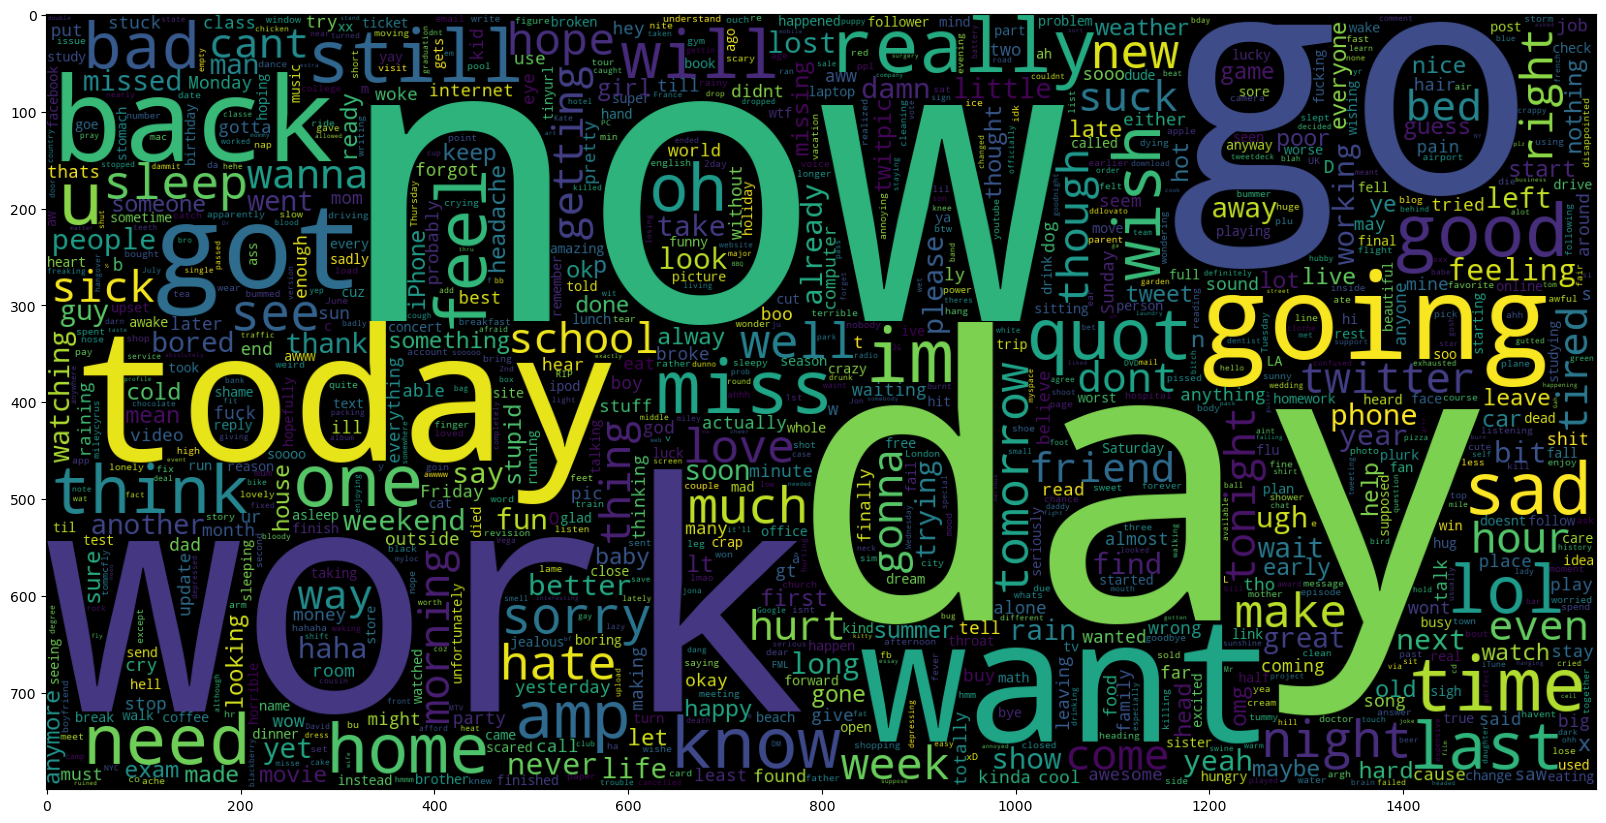

In [35]:
from wordcloud import WordCloud
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word Cloud for Positive Words

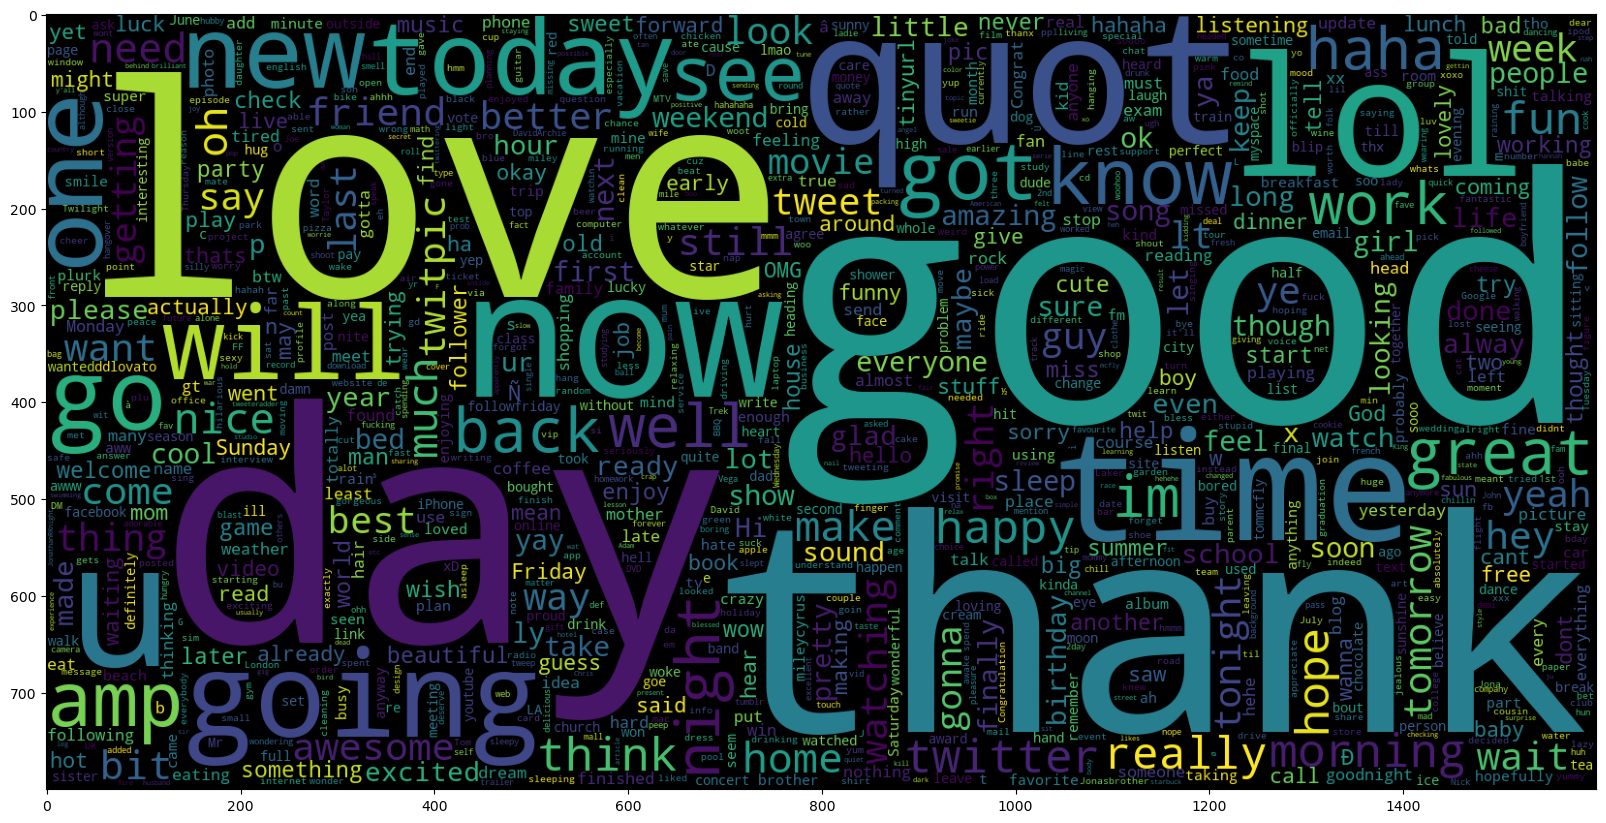

In [37]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Split the data to train test split

In [38]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

## Apply vectorizer

In [40]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [42]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

### Apply logistic Regression

In [44]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
#model_Evaluate(LRmodel)
#y_pred3 = LRmodel.predict(X_test)

C:\Users\AMANT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()